In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul 22 09:44:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 25%   32C    P0    31W / 250W |      0MiB / 12066MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   79C    P0    74W / 250W |   7736MiB / 16280MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca as Model
from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca_B as Model_B
from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca_F as Model_F
from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca_G as Model_G
from model.models_mjp_07July2020 import SimpleCNN5Layer_Ca_H as Model_H

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 20)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 17.41 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 17.06 s
Constructing 160000 event dataset took 5.646 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 4.398 s
Constructing 9984 event dataset took 0.2209 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = Model_H()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/a3ac4cb170144169b87e6158414beae9/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 6.0 parameter layers to update in the current model, 6.0 were loaded


In [10]:
model.to(device)

SimpleCNN5Layer_Ca_H(
  (conv1): Conv1d(1, 12, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(12, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(9, 6, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(6, 3, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(3, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


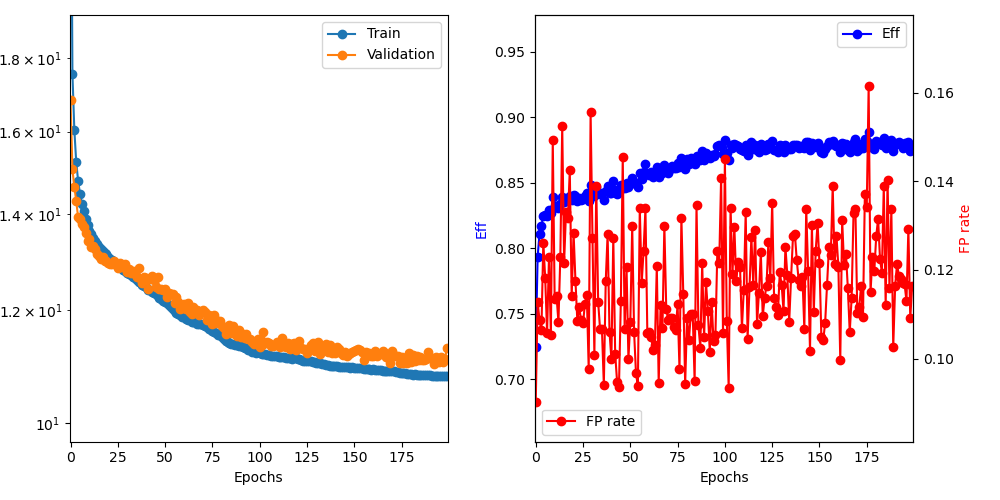

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  SimpleCNN5Layer_Ca_H(
  (conv1): Conv1d(1, 12, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(12, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(9, 6, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(6, 3, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(3, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)
epoch_start 20
batch_size 128
epochs 200
lr 0.001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 20: train=29.7718, val=16.8227, took 34.162 s
  Validation Found 39509 of 54504, added 901 (eff 72.49%) (0.0902 FP/event)


Epoch 21: train=17.5524, val=15.0582, took 33.783 s
  Validation Found 43250 of 54504, added 1126 (eff 79.35%) (0.113 FP/event)


Epoch 22: train=16.0513, val=14.6308, took 33.227 s
  Validation Found 44205 of 54504, added 1085 (eff 81.10%) (0.109 FP/event)


Epoch 23: train=15.2333, val=14.3126, took 33.636 s
  Validation Found 44537 of 54504, added 1062 (eff 81.71%) (0.106 FP/event)


Epoch 24: train=14.7819, val=13.929, took 33.424 s
  Validation Found 44955 of 54504, added 1260 (eff 82.48%) (0.126 FP/event)


Epoch 25: train=14.4723, val=13.8858, took 33.231 s
  Validation Found 44996 of 54504, added 1180 (eff 82.56%) (0.118 FP/event)


Epoch 26: train=14.2427, val=13.7791, took 33.094 s
  Validation Found 44952 of 54504, added 1057 (eff 82.47%) (0.106 FP/event)


Epoch 27: train=14.0803, val=13.7062, took 33.58 s
  Validation Found 45202 of 54504, added 1228 (eff 82.93%) (0.123 FP/event)


Epoch 28: train=13.9047, val=13.5885, took 33.089 s
  Validation Found 45067 of 54504, added 1052 (eff 82.69%) (0.105 FP/event)


Epoch 29: train=13.7626, val=13.4199, took 30.702 s
  Validation Found 45718 of 54504, added 1491 (eff 83.88%) (0.149 FP/event)


Epoch 30: train=13.6327, val=13.4613, took 27.551 s
  Validation Found 45375 of 54504, added 1133 (eff 83.25%) (0.113 FP/event)


Epoch 31: train=13.5526, val=13.2797, took 27.37 s
  Validation Found 45348 of 54504, added 1139 (eff 83.20%) (0.114 FP/event)


Epoch 32: train=13.4784, val=13.3015, took 27.447 s
  Validation Found 45275 of 54504, added 1081 (eff 83.07%) (0.108 FP/event)


Epoch 33: train=13.4132, val=13.2419, took 27.714 s
  Validation Found 45448 of 54504, added 1228 (eff 83.38%) (0.123 FP/event)


Epoch 34: train=13.3382, val=13.1356, took 27.571 s
  Validation Found 45730 of 54504, added 1522 (eff 83.90%) (0.152 FP/event)


Epoch 35: train=13.284, val=13.0952, took 27.43 s
  Validation Found 45529 of 54504, added 1215 (eff 83.53%) (0.122 FP/event)


Epoch 36: train=13.2373, val=13.027, took 27.714 s
  Validation Found 45710 of 54504, added 1329 (eff 83.87%) (0.133 FP/event)


Epoch 37: train=13.1928, val=13.0633, took 28.193 s
  Validation Found 45708 of 54504, added 1315 (eff 83.86%) (0.132 FP/event)


Epoch 38: train=13.1554, val=12.986, took 28.37 s
  Validation Found 45789 of 54504, added 1423 (eff 84.01%) (0.143 FP/event)


Epoch 39: train=13.1232, val=12.9755, took 28.23 s
  Validation Found 45616 of 54504, added 1139 (eff 83.69%) (0.114 FP/event)


Epoch 40: train=13.0721, val=12.9421, took 27.683 s
  Validation Found 45805 of 54504, added 1282 (eff 84.04%) (0.128 FP/event)


Epoch 41: train=13.0254, val=12.9146, took 27.725 s
  Validation Found 45789 of 54504, added 1173 (eff 84.01%) (0.117 FP/event)


Epoch 42: train=12.996, val=12.9311, took 27.573 s
  Validation Found 45572 of 54504, added 1083 (eff 83.61%) (0.108 FP/event)


Epoch 43: train=12.9499, val=12.9775, took 27.789 s
  Validation Found 45711 of 54504, added 1114 (eff 83.87%) (0.112 FP/event)


Epoch 44: train=12.9124, val=12.916, took 27.848 s
  Validation Found 45618 of 54504, added 1085 (eff 83.70%) (0.109 FP/event)


Epoch 45: train=12.8946, val=12.8461, took 27.644 s
  Validation Found 45658 of 54504, added 1078 (eff 83.77%) (0.108 FP/event)


Epoch 46: train=12.8723, val=12.9352, took 27.852 s
  Validation Found 45786 of 54504, added 1122 (eff 84.00%) (0.112 FP/event)


Epoch 47: train=12.8335, val=12.8637, took 27.964 s
  Validation Found 45891 of 54504, added 1141 (eff 84.20%) (0.114 FP/event)


Epoch 48: train=12.7916, val=12.8925, took 27.714 s
  Validation Found 45577 of 54504, added 975 (eff 83.62%) (0.0976 FP/event)


Epoch 49: train=12.7769, val=12.9303, took 27.875 s
  Validation Found 46218 of 54504, added 1554 (eff 84.80%) (0.156 FP/event)


Epoch 50: train=12.7444, val=12.7583, took 27.772 s
  Validation Found 46007 of 54504, added 1270 (eff 84.41%) (0.127 FP/event)


Epoch 51: train=12.7099, val=12.8257, took 27.646 s
  Validation Found 45761 of 54504, added 1007 (eff 83.96%) (0.101 FP/event)


Epoch 52: train=12.6951, val=12.746, took 27.444 s
  Validation Found 46155 of 54504, added 1388 (eff 84.68%) (0.139 FP/event)


Epoch 53: train=12.6577, val=12.7839, took 27.422 s
  Validation Found 45918 of 54504, added 1126 (eff 84.25%) (0.113 FP/event)


Epoch 54: train=12.6303, val=12.7142, took 27.61 s
  Validation Found 45840 of 54504, added 1065 (eff 84.10%) (0.107 FP/event)


Epoch 55: train=12.5884, val=12.6477, took 27.769 s
  Validation Found 45893 of 54504, added 1064 (eff 84.20%) (0.107 FP/event)


Epoch 56: train=12.561, val=12.8344, took 27.596 s
  Validation Found 45610 of 54504, added 939 (eff 83.68%) (0.094 FP/event)


Epoch 57: train=12.5311, val=12.6206, took 27.779 s
  Validation Found 45984 of 54504, added 1173 (eff 84.37%) (0.117 FP/event)


Epoch 58: train=12.4866, val=12.5378, took 27.498 s
  Validation Found 46194 of 54504, added 1279 (eff 84.75%) (0.128 FP/event)


Epoch 59: train=12.4709, val=12.6512, took 27.544 s
  Validation Found 45906 of 54504, added 1058 (eff 84.23%) (0.106 FP/event)


Epoch 60: train=12.4422, val=12.6387, took 27.524 s
  Validation Found 45907 of 54504, added 997 (eff 84.23%) (0.0998 FP/event)


Epoch 61: train=12.4003, val=12.4175, took 27.611 s
  Validation Found 46385 of 54504, added 1271 (eff 85.10%) (0.127 FP/event)


Epoch 62: train=12.386, val=12.6186, took 27.58 s
  Validation Found 46028 of 54504, added 1009 (eff 84.45%) (0.101 FP/event)


Epoch 63: train=12.3537, val=12.6821, took 27.262 s
  Validation Found 45873 of 54504, added 946 (eff 84.16%) (0.0947 FP/event)


Epoch 64: train=12.3314, val=12.5886, took 27.545 s
  Validation Found 45926 of 54504, added 935 (eff 84.26%) (0.0936 FP/event)


Epoch 65: train=12.3078, val=12.4567, took 27.781 s
  Validation Found 46228 of 54504, added 1129 (eff 84.82%) (0.113 FP/event)


Epoch 66: train=12.2815, val=12.656, took 27.623 s
  Validation Found 46225 of 54504, added 1453 (eff 84.81%) (0.146 FP/event)


Epoch 67: train=12.243, val=12.4181, took 27.561 s
  Validation Found 46117 of 54504, added 1065 (eff 84.61%) (0.107 FP/event)


Epoch 68: train=12.2046, val=12.4068, took 27.606 s
  Validation Found 46337 of 54504, added 1205 (eff 85.02%) (0.121 FP/event)


Epoch 69: train=12.1707, val=12.3917, took 27.565 s
  Validation Found 46147 of 54504, added 998 (eff 84.67%) (0.0999 FP/event)


Epoch 70: train=12.1504, val=12.4127, took 27.639 s
  Validation Found 46267 of 54504, added 1081 (eff 84.89%) (0.108 FP/event)


Epoch 71: train=12.1363, val=12.244, took 27.654 s
  Validation Found 46520 of 54504, added 1297 (eff 85.35%) (0.13 FP/event)


Epoch 72: train=12.0969, val=12.3358, took 27.263 s
  Validation Found 46308 of 54504, added 1058 (eff 84.96%) (0.106 FP/event)


Epoch 73: train=12.0607, val=12.3109, took 27.607 s
  Validation Found 46309 of 54504, added 965 (eff 84.96%) (0.0966 FP/event)


Epoch 74: train=12.0214, val=12.3197, took 27.849 s
  Validation Found 46164 of 54504, added 936 (eff 84.70%) (0.0937 FP/event)


Epoch 75: train=11.9838, val=12.1346, took 27.26 s
  Validation Found 46723 of 54504, added 1339 (eff 85.72%) (0.134 FP/event)


Epoch 76: train=11.9486, val=12.2472, took 27.29 s
  Validation Found 46490 of 54504, added 1168 (eff 85.30%) (0.117 FP/event)


Epoch 77: train=11.924, val=12.154, took 27.264 s
  Validation Found 46774 of 54504, added 1241 (eff 85.82%) (0.124 FP/event)


Epoch 78: train=11.9031, val=12.021, took 27.742 s
  Validation Found 47107 of 54504, added 1337 (eff 86.43%) (0.134 FP/event)


Epoch 79: train=11.8694, val=12.0436, took 27.687 s
  Validation Found 46705 of 54504, added 1056 (eff 85.69%) (0.106 FP/event)


Epoch 80: train=11.8561, val=12.1171, took 27.535 s
  Validation Found 46661 of 54504, added 1058 (eff 85.61%) (0.106 FP/event)


Epoch 81: train=11.8228, val=12.0135, took 27.694 s
  Validation Found 46783 of 54504, added 1047 (eff 85.83%) (0.105 FP/event)


Epoch 82: train=11.8052, val=12.1401, took 27.521 s
  Validation Found 46577 of 54504, added 1018 (eff 85.46%) (0.102 FP/event)


Epoch 83: train=11.7984, val=11.9628, took 27.615 s
  Validation Found 46761 of 54504, added 1030 (eff 85.79%) (0.103 FP/event)


Epoch 84: train=11.776, val=11.9123, took 27.744 s
  Validation Found 46998 of 54504, added 1207 (eff 86.23%) (0.121 FP/event)


Epoch 85: train=11.7782, val=12.0638, took 27.57 s
  Validation Found 46564 of 54504, added 943 (eff 85.43%) (0.0944 FP/event)


Epoch 86: train=11.7649, val=11.9904, took 27.732 s
  Validation Found 46746 of 54504, added 1120 (eff 85.77%) (0.112 FP/event)


Epoch 87: train=11.7393, val=12.0061, took 27.763 s
  Validation Found 46739 of 54504, added 1067 (eff 85.75%) (0.107 FP/event)


Epoch 88: train=11.7258, val=11.895, took 27.565 s
  Validation Found 47057 of 54504, added 1298 (eff 86.34%) (0.13 FP/event)


Epoch 89: train=11.7281, val=11.9685, took 27.635 s
  Validation Found 46808 of 54504, added 1110 (eff 85.88%) (0.111 FP/event)


Epoch 90: train=11.7097, val=11.9976, took 27.42 s
  Validation Found 46715 of 54504, added 1086 (eff 85.71%) (0.109 FP/event)


Epoch 91: train=11.701, val=11.9607, took 27.729 s
  Validation Found 46880 of 54504, added 1091 (eff 86.01%) (0.109 FP/event)


Epoch 92: train=11.6727, val=11.8087, took 27.606 s
  Validation Found 47028 of 54504, added 1090 (eff 86.28%) (0.109 FP/event)


Epoch 93: train=11.6366, val=11.8971, took 27.594 s
  Validation Found 46937 of 54504, added 1070 (eff 86.12%) (0.107 FP/event)


Epoch 94: train=11.6306, val=11.8295, took 27.578 s
  Validation Found 46944 of 54504, added 1063 (eff 86.13%) (0.106 FP/event)


Epoch 95: train=11.603, val=11.729, took 27.59 s
  Validation Found 47132 of 54504, added 1121 (eff 86.47%) (0.112 FP/event)


Epoch 96: train=11.5728, val=11.894, took 27.63 s
  Validation Found 46966 of 54504, added 974 (eff 86.17%) (0.0975 FP/event)


Epoch 97: train=11.5562, val=11.7452, took 27.56 s
  Validation Found 47374 of 54504, added 1316 (eff 86.92%) (0.132 FP/event)


Epoch 98: train=11.5327, val=11.7852, took 27.667 s
  Validation Found 47068 of 54504, added 1145 (eff 86.36%) (0.115 FP/event)


Epoch 99: train=11.5182, val=11.7902, took 27.548 s
  Validation Found 46893 of 54504, added 941 (eff 86.04%) (0.0942 FP/event)


Epoch 100: train=11.4815, val=11.6867, took 27.752 s
  Validation Found 47305 of 54504, added 1091 (eff 86.79%) (0.109 FP/event)


Epoch 101: train=11.4419, val=11.6477, took 27.599 s
  Validation Found 47124 of 54504, added 1040 (eff 86.46%) (0.104 FP/event)


Epoch 102: train=11.4208, val=11.5453, took 27.496 s
  Validation Found 47356 of 54504, added 1100 (eff 86.89%) (0.11 FP/event)


Epoch 103: train=11.3905, val=11.6157, took 27.508 s
  Validation Found 47295 of 54504, added 1098 (eff 86.77%) (0.11 FP/event)


Epoch 104: train=11.3835, val=11.7054, took 27.729 s
  Validation Found 47124 of 54504, added 947 (eff 86.46%) (0.0948 FP/event)


Epoch 105: train=11.3661, val=11.5599, took 27.531 s
  Validation Found 47437 of 54504, added 1344 (eff 87.03%) (0.135 FP/event)


Epoch 106: train=11.36, val=11.6845, took 27.715 s
  Validation Found 47368 of 54504, added 1073 (eff 86.91%) (0.107 FP/event)


Epoch 107: train=11.348, val=11.5499, took 27.599 s
  Validation Found 47279 of 54504, added 1023 (eff 86.74%) (0.102 FP/event)


Epoch 108: train=11.3441, val=11.5031, took 27.697 s
  Validation Found 47650 of 54504, added 1213 (eff 87.42%) (0.121 FP/event)


Epoch 109: train=11.3252, val=11.6169, took 27.653 s
  Validation Found 47281 of 54504, added 1046 (eff 86.75%) (0.105 FP/event)


Epoch 110: train=11.3166, val=11.4936, took 28.046 s
  Validation Found 47577 of 54504, added 1171 (eff 87.29%) (0.117 FP/event)


Epoch 111: train=11.2991, val=11.5367, took 27.595 s
  Validation Found 47472 of 54504, added 1106 (eff 87.10%) (0.111 FP/event)


Epoch 112: train=11.287, val=11.4676, took 27.531 s
  Validation Found 47362 of 54504, added 1014 (eff 86.90%) (0.102 FP/event)


Epoch 113: train=11.2833, val=11.5504, took 27.813 s
  Validation Found 47468 of 54504, added 1125 (eff 87.09%) (0.113 FP/event)


Epoch 114: train=11.2555, val=11.4563, took 27.538 s
  Validation Found 47452 of 54504, added 1037 (eff 87.06%) (0.104 FP/event)


Epoch 115: train=11.2406, val=11.4595, took 27.629 s
  Validation Found 47519 of 54504, added 1052 (eff 87.18%) (0.105 FP/event)


Epoch 116: train=11.2192, val=11.3897, took 27.892 s
  Validation Found 47838 of 54504, added 1240 (eff 87.77%) (0.124 FP/event)


Epoch 117: train=11.223, val=11.3672, took 27.512 s
  Validation Found 47883 of 54504, added 1214 (eff 87.85%) (0.122 FP/event)


Epoch 118: train=11.2004, val=11.4055, took 27.967 s
  Validation Found 47864 of 54504, added 1406 (eff 87.82%) (0.141 FP/event)


Epoch 119: train=11.2063, val=11.4571, took 27.686 s
  Validation Found 47515 of 54504, added 1057 (eff 87.18%) (0.106 FP/event)


Epoch 120: train=11.1969, val=11.2999, took 27.555 s
  Validation Found 48107 of 54504, added 1449 (eff 88.26%) (0.145 FP/event)


Epoch 121: train=11.1768, val=11.3491, took 27.596 s
  Validation Found 47584 of 54504, added 1083 (eff 87.30%) (0.108 FP/event)


Epoch 122: train=11.1727, val=11.5766, took 27.484 s
  Validation Found 47263 of 54504, added 933 (eff 86.71%) (0.0934 FP/event)


Epoch 123: train=11.1749, val=11.3693, took 27.584 s
  Validation Found 47882 of 54504, added 1339 (eff 87.85%) (0.134 FP/event)


Epoch 124: train=11.1615, val=11.3922, took 27.495 s
  Validation Found 47752 of 54504, added 1189 (eff 87.61%) (0.119 FP/event)


Epoch 125: train=11.1634, val=11.369, took 27.585 s
  Validation Found 47921 of 54504, added 1296 (eff 87.92%) (0.13 FP/event)


Epoch 126: train=11.1495, val=11.327, took 27.6 s
  Validation Found 47878 of 54504, added 1173 (eff 87.84%) (0.117 FP/event)


Epoch 127: train=11.1396, val=11.3304, took 27.644 s
  Validation Found 47851 of 54504, added 1217 (eff 87.79%) (0.122 FP/event)


Epoch 128: train=11.1349, val=11.3368, took 27.634 s
  Validation Found 47713 of 54504, added 1205 (eff 87.54%) (0.121 FP/event)


Epoch 129: train=11.1334, val=11.394, took 27.443 s
  Validation Found 47693 of 54504, added 1067 (eff 87.50%) (0.107 FP/event)


Epoch 130: train=11.1266, val=11.357, took 27.596 s
  Validation Found 47659 of 54504, added 1154 (eff 87.44%) (0.116 FP/event)


Epoch 131: train=11.1226, val=11.2975, took 27.603 s
  Validation Found 47911 of 54504, added 1329 (eff 87.90%) (0.133 FP/event)


Epoch 132: train=11.1233, val=11.4781, took 27.537 s
  Validation Found 47473 of 54504, added 1043 (eff 87.10%) (0.104 FP/event)


Epoch 133: train=11.1213, val=11.3286, took 27.596 s
  Validation Found 47752 of 54504, added 1160 (eff 87.61%) (0.116 FP/event)


Epoch 134: train=11.1117, val=11.3039, took 27.614 s
  Validation Found 48030 of 54504, added 1272 (eff 88.12%) (0.127 FP/event)


Epoch 135: train=11.1068, val=11.3718, took 27.539 s
  Validation Found 47741 of 54504, added 1165 (eff 87.59%) (0.117 FP/event)


Epoch 136: train=11.1031, val=11.2713, took 27.602 s
  Validation Found 47896 of 54504, added 1288 (eff 87.88%) (0.129 FP/event)


Epoch 137: train=11.0918, val=11.3663, took 27.382 s
  Validation Found 47689 of 54504, added 1076 (eff 87.50%) (0.108 FP/event)


Epoch 138: train=11.1162, val=11.3815, took 27.533 s
  Validation Found 47617 of 54504, added 1147 (eff 87.36%) (0.115 FP/event)


Epoch 139: train=11.1043, val=11.2558, took 27.425 s
  Validation Found 47947 of 54504, added 1238 (eff 87.97%) (0.124 FP/event)


Epoch 140: train=11.0874, val=11.3427, took 27.681 s
  Validation Found 47772 of 54504, added 1094 (eff 87.65%) (0.11 FP/event)


Epoch 141: train=11.0917, val=11.4116, took 27.619 s
  Validation Found 47708 of 54504, added 1135 (eff 87.53%) (0.114 FP/event)


Epoch 142: train=11.0685, val=11.2941, took 27.909 s
  Validation Found 47734 of 54504, added 1163 (eff 87.58%) (0.116 FP/event)


Epoch 143: train=11.0568, val=11.2678, took 27.642 s
  Validation Found 47919 of 54504, added 1261 (eff 87.92%) (0.126 FP/event)


Epoch 144: train=11.0495, val=11.2705, took 27.728 s
  Validation Found 47859 of 54504, added 1179 (eff 87.81%) (0.118 FP/event)


Epoch 145: train=11.0438, val=11.2002, took 27.723 s
  Validation Found 48059 of 54504, added 1350 (eff 88.18%) (0.135 FP/event)


Epoch 146: train=11.0482, val=11.2612, took 27.559 s
  Validation Found 47707 of 54504, added 1135 (eff 87.53%) (0.114 FP/event)


Epoch 147: train=11.0442, val=11.3475, took 27.575 s
  Validation Found 47673 of 54504, added 1114 (eff 87.47%) (0.112 FP/event)


Epoch 148: train=11.0354, val=11.3755, took 27.522 s
  Validation Found 47589 of 54504, added 1096 (eff 87.31%) (0.11 FP/event)


Epoch 149: train=11.03, val=11.2351, took 27.843 s
  Validation Found 47879 of 54504, added 1193 (eff 87.84%) (0.119 FP/event)


Epoch 150: train=11.0245, val=11.2856, took 27.593 s
  Validation Found 47846 of 54504, added 1165 (eff 87.78%) (0.117 FP/event)


Epoch 151: train=11.0166, val=11.4017, took 27.498 s
  Validation Found 47593 of 54504, added 1106 (eff 87.32%) (0.111 FP/event)


Epoch 152: train=11.0082, val=11.1823, took 27.6 s
  Validation Found 47912 of 54504, added 1251 (eff 87.91%) (0.125 FP/event)


Epoch 153: train=10.9986, val=11.2922, took 27.653 s
  Validation Found 47777 of 54504, added 1187 (eff 87.66%) (0.119 FP/event)


Epoch 154: train=10.993, val=11.25, took 27.586 s
  Validation Found 47747 of 54504, added 1081 (eff 87.60%) (0.108 FP/event)


Epoch 155: train=10.9877, val=11.3531, took 27.633 s
  Validation Found 47722 of 54504, added 1181 (eff 87.56%) (0.118 FP/event)


Epoch 156: train=10.9837, val=11.2149, took 27.573 s
  Validation Found 47890 of 54504, added 1274 (eff 87.87%) (0.128 FP/event)


Epoch 157: train=10.9704, val=11.3339, took 27.586 s
  Validation Found 47881 of 54504, added 1279 (eff 87.85%) (0.128 FP/event)


Epoch 158: train=10.9709, val=11.1905, took 27.547 s
  Validation Found 47887 of 54504, added 1220 (eff 87.86%) (0.122 FP/event)


Epoch 159: train=10.9641, val=11.2275, took 27.466 s
  Validation Found 47784 of 54504, added 1175 (eff 87.67%) (0.118 FP/event)


Epoch 160: train=10.9613, val=11.1943, took 27.539 s
  Validation Found 47868 of 54504, added 1162 (eff 87.82%) (0.116 FP/event)


Epoch 161: train=10.9561, val=11.3009, took 27.521 s
  Validation Found 47817 of 54504, added 1182 (eff 87.73%) (0.118 FP/event)


Epoch 162: train=10.9526, val=11.2715, took 27.475 s
  Validation Found 47767 of 54504, added 1065 (eff 87.64%) (0.107 FP/event)


Epoch 163: train=10.9538, val=11.2018, took 27.748 s
  Validation Found 48014 of 54504, added 1336 (eff 88.09%) (0.134 FP/event)


Epoch 164: train=10.9531, val=11.1657, took 27.611 s
  Validation Found 48007 of 54504, added 1196 (eff 88.08%) (0.12 FP/event)


Epoch 165: train=10.9451, val=11.209, took 27.639 s
  Validation Found 47677 of 54504, added 1016 (eff 87.47%) (0.102 FP/event)


Epoch 166: train=10.9448, val=11.1361, took 27.421 s
  Validation Found 47976 of 54504, added 1300 (eff 88.02%) (0.13 FP/event)


Epoch 167: train=10.9389, val=11.1824, took 27.517 s
  Validation Found 47848 of 54504, added 1103 (eff 87.79%) (0.11 FP/event)


Epoch 168: train=10.9342, val=11.1937, took 27.507 s
  Validation Found 47812 of 54504, added 1241 (eff 87.72%) (0.124 FP/event)


Epoch 169: train=10.9393, val=11.2174, took 27.473 s
  Validation Found 47970 of 54504, added 1304 (eff 88.01%) (0.131 FP/event)


Epoch 170: train=10.9219, val=11.2343, took 27.415 s
  Validation Found 47869 of 54504, added 1213 (eff 87.83%) (0.121 FP/event)


Epoch 171: train=10.9341, val=11.2568, took 27.912 s
  Validation Found 47621 of 54504, added 1048 (eff 87.37%) (0.105 FP/event)


Epoch 172: train=10.9347, val=11.2765, took 27.765 s
  Validation Found 47553 of 54504, added 1040 (eff 87.25%) (0.104 FP/event)


Epoch 173: train=10.9262, val=11.2444, took 27.441 s
  Validation Found 47733 of 54504, added 1079 (eff 87.58%) (0.108 FP/event)


Epoch 174: train=10.9216, val=11.2094, took 27.649 s
  Validation Found 47870 of 54504, added 1165 (eff 87.83%) (0.117 FP/event)


Epoch 175: train=10.9179, val=11.0771, took 27.686 s
  Validation Found 48029 of 54504, added 1249 (eff 88.12%) (0.125 FP/event)


Epoch 176: train=10.9153, val=11.2113, took 27.429 s
  Validation Found 47923 of 54504, added 1233 (eff 87.93%) (0.123 FP/event)


Epoch 177: train=10.9044, val=11.1503, took 27.51 s
  Validation Found 48060 of 54504, added 1387 (eff 88.18%) (0.139 FP/event)


Epoch 178: train=10.9105, val=11.1906, took 27.357 s
  Validation Found 47882 of 54504, added 1211 (eff 87.85%) (0.121 FP/event)


Epoch 179: train=10.8942, val=11.1344, took 27.515 s
  Validation Found 47872 of 54504, added 1274 (eff 87.83%) (0.128 FP/event)


Epoch 180: train=10.9015, val=11.1373, took 27.605 s
  Validation Found 47892 of 54504, added 1206 (eff 87.87%) (0.121 FP/event)


Epoch 181: train=10.8937, val=11.2379, took 27.427 s
  Validation Found 47604 of 54504, added 995 (eff 87.34%) (0.0996 FP/event)


Epoch 182: train=10.8972, val=11.1424, took 27.411 s
  Validation Found 47995 of 54504, added 1310 (eff 88.06%) (0.131 FP/event)


Epoch 183: train=10.8849, val=11.1859, took 27.514 s
  Validation Found 47929 of 54504, added 1210 (eff 87.94%) (0.121 FP/event)


Epoch 184: train=10.8897, val=11.1822, took 27.518 s
  Validation Found 47956 of 54504, added 1235 (eff 87.99%) (0.124 FP/event)


Epoch 185: train=10.8827, val=11.2335, took 27.219 s
  Validation Found 47681 of 54504, added 1157 (eff 87.48%) (0.116 FP/event)


Epoch 186: train=10.8802, val=11.2009, took 27.598 s
  Validation Found 47604 of 54504, added 1058 (eff 87.34%) (0.106 FP/event)


Epoch 187: train=10.8809, val=11.1222, took 27.469 s
  Validation Found 47756 of 54504, added 1135 (eff 87.62%) (0.114 FP/event)


Epoch 188: train=10.8792, val=11.1201, took 27.485 s
  Validation Found 48013 of 54504, added 1326 (eff 88.09%) (0.133 FP/event)


Epoch 189: train=10.8716, val=11.0148, took 27.654 s
  Validation Found 48142 of 54504, added 1336 (eff 88.33%) (0.134 FP/event)


Epoch 190: train=10.8761, val=11.2288, took 27.473 s
  Validation Found 47665 of 54504, added 1101 (eff 87.45%) (0.11 FP/event)


Epoch 191: train=10.8679, val=11.1373, took 27.813 s
  Validation Found 47733 of 54504, added 1114 (eff 87.58%) (0.112 FP/event)


Epoch 192: train=10.8592, val=11.1383, took 27.496 s
  Validation Found 47922 of 54504, added 1162 (eff 87.92%) (0.116 FP/event)


Epoch 193: train=10.8519, val=11.1401, took 27.589 s
  Validation Found 47779 of 54504, added 1092 (eff 87.66%) (0.109 FP/event)


Epoch 194: train=10.8447, val=11.0091, took 27.549 s
  Validation Found 48160 of 54504, added 1370 (eff 88.36%) (0.137 FP/event)


Epoch 195: train=10.8371, val=11.1303, took 27.502 s
  Validation Found 48076 of 54504, added 1340 (eff 88.21%) (0.134 FP/event)


Epoch 196: train=10.8423, val=11.0231, took 27.626 s
  Validation Found 48457 of 54504, added 1612 (eff 88.91%) (0.161 FP/event)


Epoch 197: train=10.8323, val=11.1122, took 27.687 s
  Validation Found 47796 of 54504, added 1148 (eff 87.69%) (0.115 FP/event)


Epoch 198: train=10.8298, val=11.0097, took 27.572 s
  Validation Found 47948 of 54504, added 1228 (eff 87.97%) (0.123 FP/event)


Epoch 199: train=10.8182, val=11.1987, took 27.588 s
  Validation Found 47722 of 54504, added 1196 (eff 87.56%) (0.12 FP/event)


Epoch 200: train=10.822, val=11.0284, took 27.555 s
  Validation Found 48061 of 54504, added 1274 (eff 88.18%) (0.128 FP/event)


Epoch 201: train=10.8116, val=11.1572, took 27.606 s
  Validation Found 47977 of 54504, added 1314 (eff 88.02%) (0.132 FP/event)


Epoch 202: train=10.8187, val=11.0568, took 27.516 s
  Validation Found 48017 of 54504, added 1224 (eff 88.10%) (0.123 FP/event)


Epoch 203: train=10.811, val=11.147, took 27.893 s
  Validation Found 47893 of 54504, added 1192 (eff 87.87%) (0.119 FP/event)


Epoch 204: train=10.8025, val=11.0678, took 27.399 s
  Validation Found 48201 of 54504, added 1387 (eff 88.44%) (0.139 FP/event)


Epoch 205: train=10.8102, val=11.1228, took 27.437 s
  Validation Found 47762 of 54504, added 1119 (eff 87.63%) (0.112 FP/event)


Epoch 206: train=10.8071, val=11.0753, took 27.586 s
  Validation Found 48034 of 54504, added 1401 (eff 88.13%) (0.14 FP/event)


Epoch 207: train=10.8061, val=11.0722, took 27.233 s
  Validation Found 47984 of 54504, added 1158 (eff 88.04%) (0.116 FP/event)


Epoch 208: train=10.8032, val=11.0947, took 27.54 s
  Validation Found 48107 of 54504, added 1335 (eff 88.26%) (0.134 FP/event)


Epoch 209: train=10.8038, val=11.2139, took 27.546 s
  Validation Found 47630 of 54504, added 1024 (eff 87.39%) (0.103 FP/event)


Epoch 210: train=10.7991, val=11.107, took 27.565 s
  Validation Found 47895 of 54504, added 1161 (eff 87.87%) (0.116 FP/event)


Epoch 211: train=10.7956, val=11.1018, took 27.222 s
  Validation Found 47971 of 54504, added 1212 (eff 88.01%) (0.121 FP/event)


Epoch 212: train=10.7959, val=10.9969, took 27.229 s
  Validation Found 48024 of 54504, added 1185 (eff 88.11%) (0.119 FP/event)


Epoch 213: train=10.7957, val=11.1309, took 27.278 s
  Validation Found 47955 of 54504, added 1177 (eff 87.98%) (0.118 FP/event)


Epoch 214: train=10.7845, val=11.0891, took 27.23 s
  Validation Found 47786 of 54504, added 1168 (eff 87.67%) (0.117 FP/event)


Epoch 215: train=10.7929, val=11.0332, took 27.633 s
  Validation Found 47972 of 54504, added 1166 (eff 88.02%) (0.117 FP/event)


Epoch 216: train=10.7808, val=11.131, took 27.429 s
  Validation Found 47909 of 54504, added 1128 (eff 87.90%) (0.113 FP/event)


Epoch 217: train=10.7827, val=11.0399, took 27.585 s
  Validation Found 48014 of 54504, added 1291 (eff 88.09%) (0.129 FP/event)


Epoch 218: train=10.7867, val=11.0847, took 27.502 s
  Validation Found 47652 of 54504, added 1089 (eff 87.43%) (0.109 FP/event)


Epoch 219: train=10.7813, val=11.2885, took 27.548 s
  Validation Found 47756 of 54504, added 1163 (eff 87.62%) (0.116 FP/event)



<IPython.core.display.Javascript object>


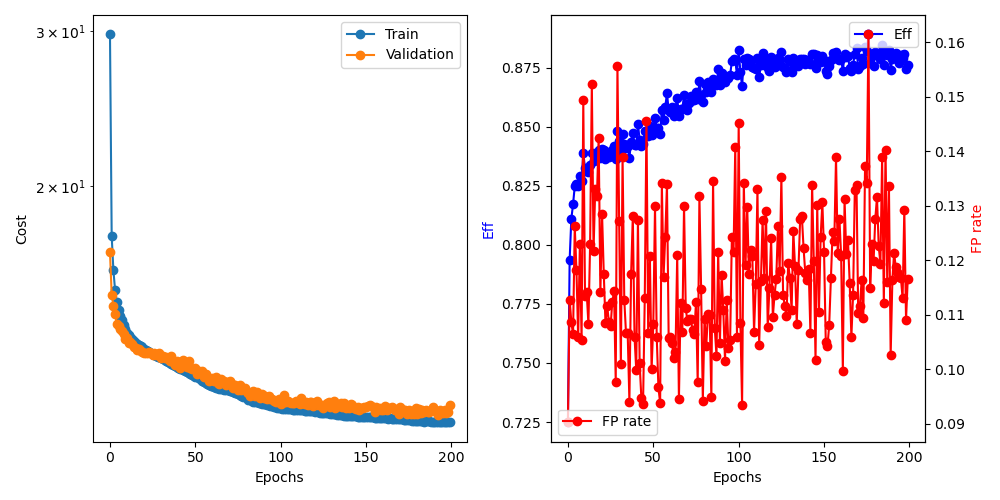

In [12]:
print('for model: ', model)   
run_name = 'SimpleCNN5Layer_Ca H'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))            
            
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    plt.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()